## Algorithm training using EigenFaces

##### References --> 
##### 1.) https://www.geeksforgeeks.org/ml-face-recognition-using-eigenfaces-pca-algorithm/
##### 2.) https://www.youtube.com/watch?v=5HNr_j6LmPc

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
face_cascade = cv2.CascadeClassifier(cv2.haarcascades + "haarcascade_frontalface_default.xml")

images = []
ndim = (40,40)
df_faces = pd.read_csv("yalefaces/yalefaces.csv", names = ["Label","x","y","w","h","Path","W","H"])
images_paths = df_faces["Path"].values
Labels = df_faces['Label'].values
for count , image_path in enumerate(images_paths):
    img = cv2.imread("yalefaces2/" + image_path, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    if faces != () :
        x,y,w,h = faces[0][0], faces[0][1], faces[0][2], faces[0][3]
        img = img[y:y+h, x:x+w]
        img = cv2.resize(img, ndim)
        img = np.asarray(img,dtype=float)/255.0 
        images.append(img.flatten())
    else:
        img = cv2.resize(img, ndim)
        img = np.asarray(img,dtype=float)/255.0
        images.append(img.flatten())

In [3]:
import random
def shuffle_split(X, Y):
    no_for_test, no_for_train = [], []
    count = 0
    while count != 33:
        x = random.randint(0,165)
        if (x in no_for_test) or (x in no_for_train):
            continue
        else:
            no_for_test.append(x)
            count+=1
    count = 0
    while count!=133:
        x = random.randint(0,165)
        if (x in no_for_train) or (x in no_for_test):
            continue
        else:
            no_for_train.append(x)
            count+=1
    return X[no_for_train,], Y[no_for_train], X[no_for_test,], Y[no_for_test]

images = np.matrix(images)
# images.shape
X, Y = images, Labels
X_train, Y_train, X_test, Y_test = shuffle_split(X,Y)

flattened_images = X_train
# images = np.array(images).T # Shape of image vector = (40*40) x 166 [N^2 X M]
A_transpose = np.matrix(flattened_images)
A = np.transpose(A_transpose)

X_train.shape , Y_train.shape , X_test.shape, Y_test.shape

((133, 1600), (133,), (33, 1600), (33,))

In [5]:
def griddisplay(image_list):
    fig1, axes_array = plt.subplots(5, 5)
    fig1.set_size_inches(5,5)
    k=0
    for row in range(5):
        for col in range(5):    
            im = cv2.resize(image_list[k],(40,40))
            image_plot = axes_array[row][col].imshow(im,cmap=plt.cm.gray) 
            axes_array[row][col].axis('off')
            k = k+1
    plt.show()

mean = np.mean(A, 1)

Text(0.5, 1.0, 'Average Face')

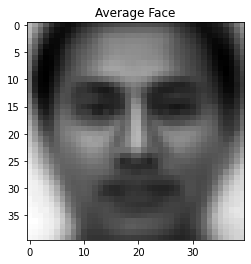

In [7]:
import matplotlib.pyplot as plt
temp_image = mean.reshape(40,40)
plt.imshow(temp_image, cmap = "gray")
plt.title("Average Face")

In [20]:
zero_mean =[]
column =0
# print(flattened_images.shape)
# print(mean.shape)
Zero_mean_matrix = np.ones((1600, 133))
for values in flattened_images:
    zm= A[:,column] - mean
    zm = np.squeeze(zm)
    Zero_mean_matrix[:,column] = zm
    zm_images = zm.resize(40,40)
    zero_mean.append(zm)
    column = column + 1
print(Zero_mean_matrix.shape)

(1600, 133)


In [26]:
d = (np.dot(np.transpose(Zero_mean_matrix),Zero_mean_matrix))/40 #Covariance
u_list =[] #EigenFaces
w2, v2 = np.linalg.eigh(d)
print(w2.shape, v2.shape)
for ev in v2:
    ev_transpose = np.transpose(np.matrix(ev))
    u = np.dot(Zero_mean_matrix, ev_transpose)
    #norms = np.linalg.norm(u, axis=0)                           
    u = u / np.linalg.norm(u)
    #     minu = np.min(u)
    #     maxu = np.max(u)
    #     u = u-float(minu)
    #     u = u/float((maxu-minu)) 
    u_i = u.reshape(40,40)
    u_list.append(u_i)
# print(u_i.shape, len(u_list))

(133,) (133, 133)


		k=2


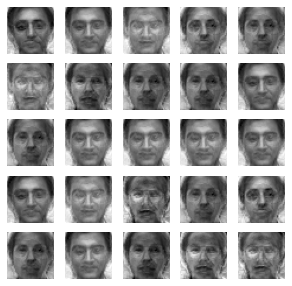

		k=5


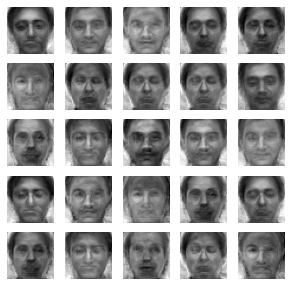

		k=15


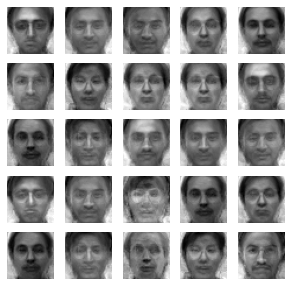

In [27]:
dict = {}
import scipy
def Reconstruct(k, boolean):
    weights = np.zeros((133,k))
    matrixU = np.zeros((1600,k))
    c = 0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    rec_face=[]
    for face_num in range(0,133): # Finding Weights of faces
        w = np.dot(np.transpose(matrixU) ,Zero_mean_matrix[:,face_num])
        #w = Zero_mean_matrix[:,face_num]*np.transpose(matrixU)  
        weights[face_num,:] = w
        #face=np.zeros((1, 180625))
        #         face = np.dot(w[0], matrixU[:,0])
        #         for i in range(1,k):
        #             face = face + np.dot(w[i], matrixU[:,i])
        #         #print(face.shape)
        #         face = face+np.transpose(mean)

        face = np.dot(w, np.transpose(matrixU))
        minf = np.min(face)
        maxf = np.max(face)
        face = face-float(minf)
        face = face/float((maxf-minf))
        face = face+np.transpose(mean)
        reshape_face = face.reshape(40,40)
        rec_face.append( reshape_face)
    if boolean is True:
        griddisplay(rec_face)
    dict[k] = weights

print('\t\tk=2')
Reconstruct(2,True)
print('\t\tk=5')
Reconstruct(5,True)
print('\t\tk=15')
Reconstruct(15,True)


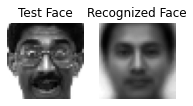

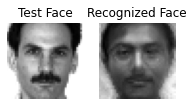

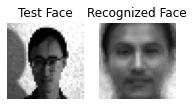

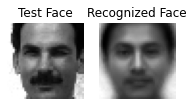

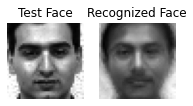

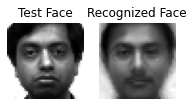

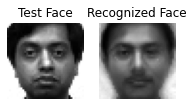

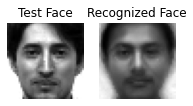

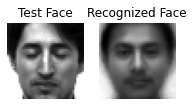

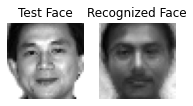

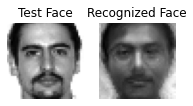

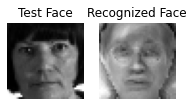

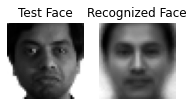

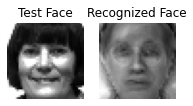

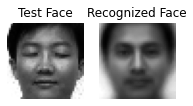

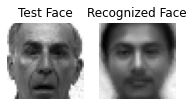

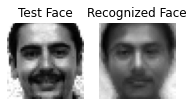

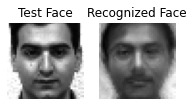

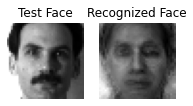

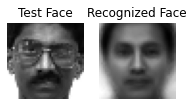

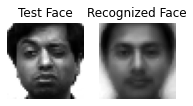

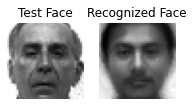

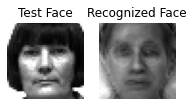

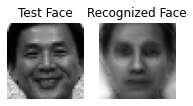

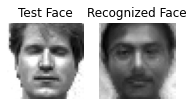

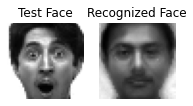

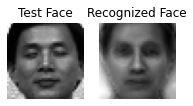

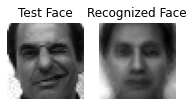

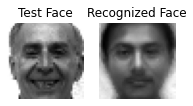

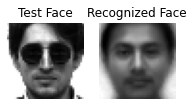

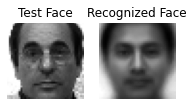

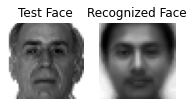

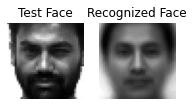

		k=5


In [68]:
test_images = X_test
def Project(k,zero_mean_test,threshold):
    matrixU = np.zeros((1600,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    w = np.dot(np.transpose(matrixU) ,np.transpose(zero_mean_test))
    original_w_k =dict[k]
    dist =[]
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors-w.T))

    nearest_face = np.argmin(dist)
    nearest_face_weights = original_w_k[nearest_face]
    fig1, axes_array = plt.subplots(1, 2)
    fig1.set_size_inches(3,3)
    zero_mean_test =zero_mean_test + np.transpose(mean)
    zero_mean_test = zero_mean_test.reshape(40,40)
    image_plot = axes_array[0].imshow(zero_mean_test,cmap=plt.cm.gray)
    axes_array[0].axis('off')
    axes_array[0].set(title='Test Face')

    face = np.dot(nearest_face_weights, np.transpose(matrixU))
    face = face+np.transpose(mean)
    reshape_face = face.reshape(40,40)
    if np.min(dist)<threshold:  #Nonface
        image_plot = axes_array[1].imshow(reshape_face,cmap=plt.cm.gray)
    axes_array[1].axis('off')
    axes_array[1].set(title ='Recognized Face')
    plt.show()
    
def runs(k):
    for num in range(0,len(test_images)):#t in test_images:
        t = test_images[num]
        test = t.flatten()
        zero_mean_test = test-np.transpose(mean)
        Project(k,zero_mean_test,80)  #threshold =80

runs(2)
print('\t\tk=5')
runs(5)
print('\t\tk=15')
runs(15)

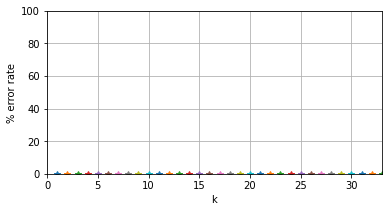

In [69]:
#Task 4
def Error(k,threshold):
    Nonfaces = 0
    total_images = 33
    nf_detected = 0
    matrixU = np.zeros((1600,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    for t in test_images:
        test = t.flatten()
        zero_mean_test = test-np.transpose(mean)
        w = np.dot(np.transpose(matrixU) ,np.transpose(zero_mean_test))
        original_w_k =dict[k]
        dist =[]
        for wt_vectors in original_w_k:
            dist.append(np.linalg.norm(wt_vectors-w.T))
        if np.min(dist) >threshold:
            nf_detected = nf_detected+1
    error_percentage = ((Nonfaces - nf_detected)/total_images)*100
    return error_percentage

xt =[]
for x in range(1,34):
    Reconstruct(x,False)
    xt.append(x)
#print(x)
#xt=[2,5,15]


fig, axes1 = plt.subplots(1, 1)
fig.set_size_inches(6,3)
for x_pts in xt:
    y= Error(x_pts,80)
    axes1.plot(x_pts, y,marker='*')
axes1.set(xlabel="k",ylabel="% error rate",ylim=(0,100),xlim=(0,33))
plt.grid(True)
plt.show()
